In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Data Loading

In [2]:
# load data
df = pd.read_csv('cus_seg.csv')
# check the null values
df.head()

,ID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# drop null values
df.dropna(subset=['Description','CustomerID'],inplace=True)

In [4]:
df.isnull().sum()

ID             0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
# only take one country
df = df[df.Country== 'United Kingdom']
# create new colums returns
df['Return']=df.InvoiceNo.str.contains('C')
# store the result in purchase 
df['Purchase'] = np.where(df["Return"]==True,0,1)

# Create customer-level dataset

In [6]:
# create new dataframe customer
customers = pd.DataFrame({'CustomerID': df['CustomerID'].unique()},dtype=int)

# calculate the recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Recency'] = pd.to_datetime("2011-12-10") - (df['InvoiceDate'])

# remove the time factor
df.Recency = df.Recency.dt.days

# purchase equal to one 
temp = df[df['Purchase']==1]

# customers latest purchase day
recency=temp.groupby(by='CustomerID',as_index=False).min()
customers=customers.merge(recency[['CustomerID','Recency']],on='CustomerID')

# Calculate the frequency of Purchase

In [7]:
# Removing invoice number duplicates

temp_1=df[['CustomerID','InvoiceNo','Purchase']]
temp_1.drop_duplicates(subset=['InvoiceNo'],inplace=True)

# calculte the frequency of the purchases
annual_invoice=temp_1.groupby(by='CustomerID',as_index=False).sum()
annual_invoice.rename(columns={'Purchase':'Frequency'},inplace=True)

# merge in the Customer
customers=customers.merge(annual_invoice,on='CustomerID')
print(customers.shape)

(3921, 3)


C:\Users\SHRIK\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Calculate the Monetary

In [8]:
# code starts here
df['Amount'] = df['Quantity']*df['UnitPrice']
annual_sales = df.groupby(by='CustomerID',as_index=False).sum()
#print(annual_sales)
annual_sales.rename(columns={'Amount':'monetary'},inplace=True)
customers = customers.merge(annual_sales[['CustomerID','monetary']])
customers.head()

,CustomerID,Recency,Frequency,monetary
0,17850,372,34,5288.63
1,13047,31,10,3079.10
2,13748,95,5,948.25
3,15100,333,3,635.10
4,15291,25,15,4596.51


# Data preprocessing

In [9]:
# code ends here
customers['monetary']=np.where(customers['monetary']<0,0,customers['monetary'])    

# log transform
customers['Recency_log']=np.log(customers['Recency']+0.1)
customers['Frequency_log']=np.log(customers['Frequency'])
customers['Monetary_log']=np.log(customers['monetary']+0.1)
customers.head()

,CustomerID,Recency,Frequency,monetary,Recency_log,Frequency_log,Monetary_log
0,17850,372,34,5288.63,5.919163,3.526361,8.573333
1,13047,31,10,3079.10,3.437208,2.302585,8.032425
2,13748,95,5,948.25,4.554929,1.609438,6.854724
3,15100,333,3,635.10,5.808443,1.098612,6.453940
4,15291,25,15,4596.51,3.222868,2.708050,8.433074


# Elbow method to find optimal number of clusters

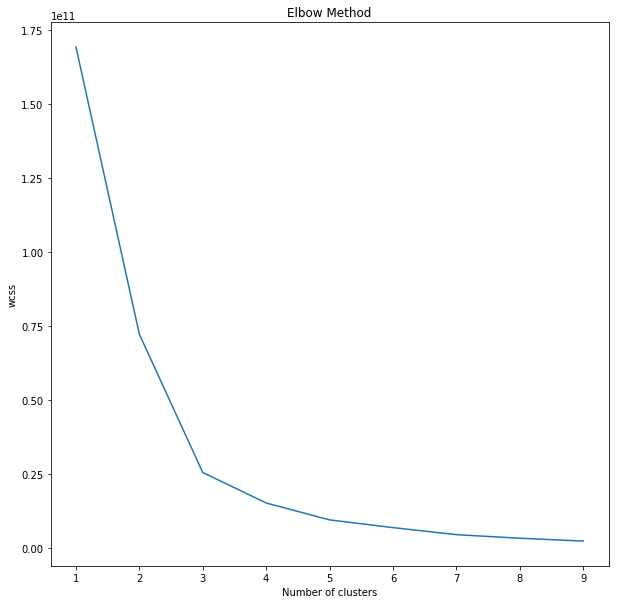

In [10]:
# Empty list for storing WCSS across all values of k
dist = []

# Iterate from 1-9
for i in range(1,10):
    # Initialize KMeans algorithm
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit on data
    km.fit(customers.iloc[:,1:7])
    # Append WCSS to list storing WCSS
    dist.append(km.inertia_)

# Initialize figure
plt.figure(figsize=(10,10))

# Line plot # clusters on X-axis and WCSS on Y-axis 
plt.plot(range(1,10),dist)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

# Code ends here

# Use Kmeans to cluster data

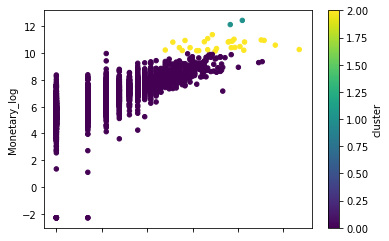

In [11]:
# initialize KMeans object
cluster = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

# create 'cluster' column
customers['cluster'] = cluster.fit_predict(customers.iloc[:,1:7])

# plot the cluster
customers.plot.scatter(x= 'Frequency_log', y= 'Monetary_log', c='cluster', colormap='viridis')

plt.show()